In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils as utils


In [2]:
# Cell 2: Define the ODE System for the Three-Cell System
# Define the parameters for the three-cell system
a = [0.1, 0.05, -0.02]  # self-regulation coefficients for each cell
b = [0.05, 0.1, 0.07]   # interaction coefficients

# Define the system of ODEs for the three-cell dynamics
def cell_system(state, t, a, b):
    C1, C2, C3 = state
    dC1_dt = a[0] * C1 + b[0] * (C2 + C3)
    dC2_dt = a[1] * C2 + b[1] * (C1 + C3)
    dC3_dt = a[2] * C3 + b[2] * (C1 + C2)
    return [dC1_dt, dC2_dt, dC3_dt]

# Initial conditions for the cell states
initial_state = [1.0, 0.5, 0.2]


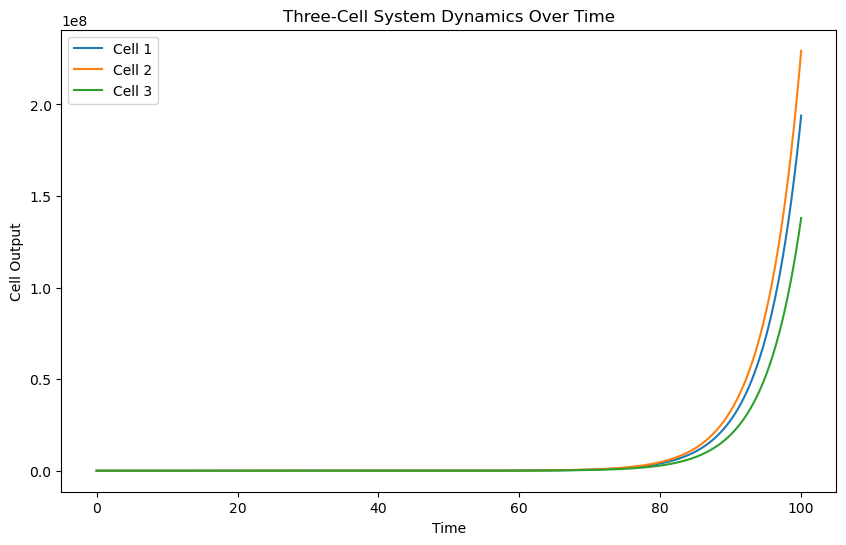

In [3]:
# Cell 3: Simulate the ODE System
# Time points for the simulation
time_points = np.linspace(0, 100, 1000)  # Simulate for 1000 steps

# Integrate the ODEs using scipy's odeint
states = odeint(cell_system, initial_state, time_points, args=(a, b))

# Plot the simulation results
plt.figure(figsize=(10, 6))
plt.plot(time_points, states[:, 0], label='Cell 1')
plt.plot(time_points, states[:, 1], label='Cell 2')
plt.plot(time_points, states[:, 2], label='Cell 3')
plt.xlabel('Time')
plt.ylabel('Cell Output')
plt.title('Three-Cell System Dynamics Over Time')
plt.legend()
plt.show()


In [4]:
# Cell 4: Define the Generator and Discriminator
# Define the Generator with Batch Normalization
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, noise_dim=5):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            utils.spectral_norm(nn.Linear(input_size + noise_dim, hidden_size)),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            utils.spectral_norm(nn.Linear(hidden_size, hidden_size)),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, noise):
        x = torch.cat((x, noise), dim=1)
        return self.network(x)

# Define the Discriminator with Layer Normalization
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.network(x)

# Gradient penalty function for regularization
def compute_gradient_penalty(discriminator, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1).expand_as(real_data)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)

    disc_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates, inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Noise injection function
def add_noise(input, noise_factor=0.05):
    noise = noise_factor * torch.randn_like(input)
    return input + noise


In [5]:
# Hyperparameters
input_size = 3
hidden_size = 16
output_size = 3
noise_dim = 5
num_epochs = 5000
lr_gen = 0.00005
lr_disc = 0.00001  # Further reduced learning rate for discriminator
lambda_gp = 5

# Instantiate networks
generator = Generator(input_size, hidden_size, output_size, noise_dim=noise_dim)
discriminator = Discriminator(output_size, hidden_size)

# Optimizers with weight decay (AdamW)
optimizer_gen = optim.AdamW(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999), weight_decay=0.01)
optimizer_disc = optim.AdamW(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.999), weight_decay=0.01)

# Learning Rate Scheduler using ReduceLROnPlateau
scheduler_gen = optim.lr_scheduler.ReduceLROnPlateau(optimizer_gen, mode='min', factor=0.5, patience=10, min_lr=1e-7, verbose=True)
scheduler_disc = optim.lr_scheduler.ReduceLROnPlateau(optimizer_disc, mode='min', factor=0.5, patience=10, min_lr=1e-7, verbose=True)


In [6]:
# Initialize lists to store loss values for visualization
gen_losses = []
disc_losses = []

# Training loop with integrated noise injection, label smoothing, and feature matching
for epoch in range(num_epochs):
    for _ in range(5):
        real_data = torch.tensor(states[:-1], dtype=torch.float32)
        real_data = add_noise(real_data, noise_factor=0.05)  # Add noise to discriminator input
        noise = torch.randn(real_data.size(0), noise_dim)
        fake_data = generator(real_data, noise).detach()

        optimizer_disc.zero_grad()
        loss_disc_real = -0.9 * torch.mean(discriminator(real_data))  # Label smoothing for real data
        loss_disc_fake = torch.mean(discriminator(fake_data))
        gradient_penalty = compute_gradient_penalty(discriminator, real_data, fake_data)
        loss_disc = loss_disc_real + loss_disc_fake + lambda_gp * gradient_penalty
        loss_disc.backward()
        utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        optimizer_disc.step()

    optimizer_gen.zero_grad()
    noise = torch.randn(real_data.size(0), noise_dim)
    fake_data = generator(real_data, noise)

    # Feature matching for generator loss
    fake_features = discriminator(fake_data).mean()
    real_features = discriminator(real_data).mean().detach()
    feature_matching_loss = F.mse_loss(fake_features, real_features)

    loss_gen = -torch.mean(discriminator(fake_data)) + 0.1 * feature_matching_loss
    loss_gen.backward()
    utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
    optimizer_gen.step()

    # Adjust learning rate based on loss progression
    scheduler_gen.step(loss_gen)
    scheduler_disc.step(loss_disc)

    # Record losses for visualization
    gen_losses.append(loss_gen.item())
    disc_losses.append(loss_disc.item())

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss Disc: {loss_disc.item()}, Loss Gen: {loss_gen.item()}')


Epoch [0/5000], Loss Disc: 5.023331642150879, Loss Gen: 0.07089384645223618
Epoch 00012: reducing learning rate of group 0 to 2.5000e-05.
Epoch 00023: reducing learning rate of group 0 to 1.2500e-05.
Epoch 00034: reducing learning rate of group 0 to 6.2500e-06.
Epoch 00045: reducing learning rate of group 0 to 3.1250e-06.
Epoch 00056: reducing learning rate of group 0 to 1.5625e-06.
Epoch 00067: reducing learning rate of group 0 to 7.8125e-07.
Epoch 00078: reducing learning rate of group 0 to 3.9063e-07.
Epoch 00089: reducing learning rate of group 0 to 1.9531e-07.
Epoch 00097: reducing learning rate of group 0 to 5.0000e-06.
Epoch 00100: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00119: reducing learning rate of group 0 to 2.5000e-06.
Epoch 00130: reducing learning rate of group 0 to 1.2500e-06.
Epoch 00141: reducing learning rate of group 0 to 6.2500e-07.
Epoch 00152: reducing learning rate of group 0 to 3.1250e-07.
Epoch 00165: reducing learning rate of group 0 to 1.5625

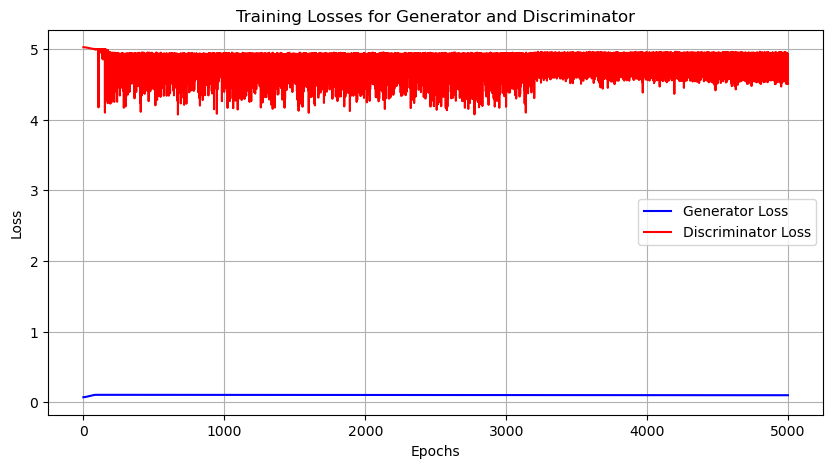

In [7]:
# Cell 7: Visualization of Training Losses
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss', color='blue')
plt.plot(disc_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses for Generator and Discriminator')
plt.grid(True)
plt.show()


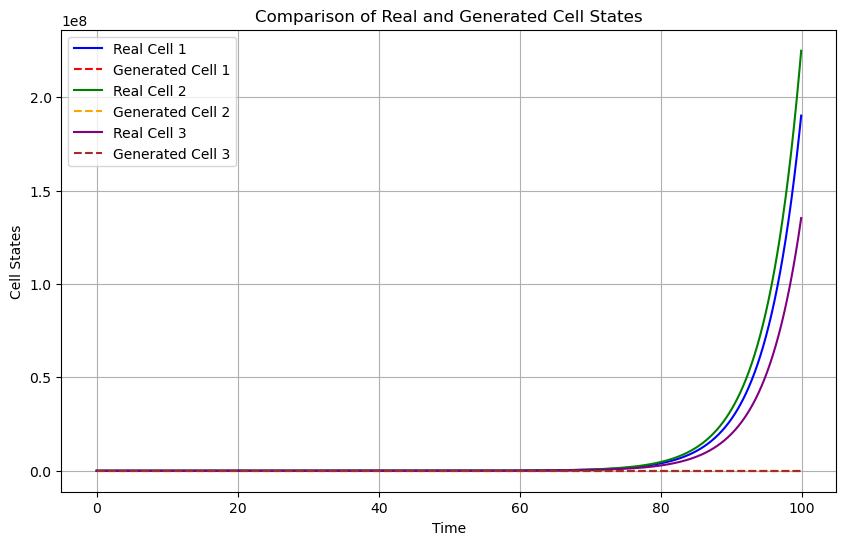

In [11]:
# Plot the generated cell states compared to the real cell states
with torch.no_grad():
    noise = torch.randn(states.shape[0] - 1, noise_dim)
    generated_states = generator(torch.tensor(states[:-1], dtype=torch.float32), noise).numpy()

plt.figure(figsize=(10, 6))
plt.plot(time_points[:-1], states[:-1, 0], label='Real Cell 1', color='blue')
plt.plot(time_points[:-1], generated_states[:, 0], label='Generated Cell 1', linestyle='--', color='red')

plt.plot(time_points[:-1], states[:-1, 1], label='Real Cell 2', color='green')
plt.plot(time_points[:-1], generated_states[:, 1], label='Generated Cell 2', linestyle='--', color='orange')

plt.plot(time_points[:-1], states[:-1, 2], label='Real Cell 3', color='purple')
plt.plot(time_points[:-1], generated_states[:, 2], label='Generated Cell 3', linestyle='--', color='brown')

plt.xlabel('Time')
plt.ylabel('Cell States')
plt.title('Comparison of Real and Generated Cell States')
plt.legend()
plt.grid(True)
plt.show()
